### ========  make categorical level labels  ========

In [1]:
import os 
import numpy as np
import tensorflow as tf
print(tf.__version__)
tf.debugging.set_log_device_placement(True)

labels = [
    (  'void'  , (  0,  0,  0) ), 
    (  'void'  , (111, 74,  0) ),
    (  'void'  , ( 81,  0, 81) ),
    (  'flat'  , (128, 64,128) ),
    (  'flat'  , (244, 35,232) ),
    (  'flat'  , (250,170,160) ),
    (  'flat'  , (230,150,140) ),
    (  'construction'  , ( 70, 70, 70) ),
    (  'construction'  , (102,102,156) ),
    (  'construction'  , (190,153,153) ),
    (  'construction'  , (180,165,180) ),
    (  'construction'  , (150,100,100) ),
    (  'construction'  , (150,120, 90) ),
    (  'object'    , (153,153,153) ),
    (  'object'    , (153,153,153) ),
    (  'object'    , (250,170, 30) ),
    (  'object'    , (220,220,  0) ),
    (  'nature'    , (107,142, 35) ),
    (  'nature'    , (152,251,152) ),
    (  'sky'       , ( 70,130,180) ),
    (  'human'     , (220, 20, 60) ),
    (  'human'     , (255,  0,  0) ),
    (  'vehicle'   , (  0,  0,142) ),
    (  'vehicle'   , (  0,  0, 70) ),
    (  'vehicle'   , (  0, 60,100) ),
    (  'vehicle'   , (  0,  0, 90) ),
    (  'vehicle'   , (  0,  0,110) ),
    (  'vehicle'   , (  0, 80,100) ),
    (  'vehicle'   , (  0,  0,230) ),
    (  'vehicle'   , (119, 11, 32) )]

category=dict([('void',0),('flat',1),('construction',2),('object',3),('nature',4),('sky',5),('human',6),('vehicle',7)])
reversed_category=dict([(v,k) for (k,v) in category.items()])
reversed_category.items()
print(category.items(), len(category))
print(reversed_category.items(), len(reversed_category))



2.0.0
dict_items([('void', 0), ('flat', 1), ('construction', 2), ('object', 3), ('nature', 4), ('sky', 5), ('human', 6), ('vehicle', 7)]) 8
dict_items([(0, 'void'), (1, 'flat'), (2, 'construction'), (3, 'object'), (4, 'nature'), (5, 'sky'), (6, 'human'), (7, 'vehicle')]) 8


## ======== constructing tf.data pipeline to read in the data from filenames ========


In [2]:
import tensorflow as tf
print(tf.__version__)
tf.executing_eagerly()
import argparse
import numpy as np
import os

def decode_img(colored_image,ch=3):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(colored_image, channels=ch)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.

    return img

def process_path(img_file_path):
    mask_file_path=tf.strings.regex_replace(img_file_path,'img','gt_cat')
    mask_file_path=tf.strings.regex_replace(mask_file_path,'_leftImg8bit.png', '_gtFine_color.png')# '_gtFine_labelIds.png')
    #print(img_file_path,mask_file_path)
    img_file = tf.io.read_file(img_file_path)
    mask_file = tf.io.read_file(mask_file_path)
    
    #gt_file=tf.io.read_file(mask_file_path)
    im=decode_img(img_file)
    gt=decode_img(mask_file,ch=1)
    print(im.shape, gt.shape)
    
    return im,gt

def adapt_types_and_transpose(im, gt):
    im = tf.cast(im, tf.float32)
    gt = tf.cast(gt, tf.uint8)
    return im, gt

def one_hot(image, gt):
    gt_shape = tf.shape(gt)
    gt = tf.reshape(gt, gt_shape[:-1])
    gt = tf.one_hot(gt, 8)
    return image, gt

AUTOTUNE = tf.data.experimental.AUTOTUNE
img_files = tf.data.Dataset.list_files('/workspace/8data/img/*.png')

dataset=img_files.map(lambda x: process_path(x)) 
# adapt the data types, images to fp16, gt (one_hot) stay in int close before softmax calc
dataset = dataset.map(adapt_types_and_transpose)
dataset = dataset.map(one_hot)
#how_many=int(args.test)

##### print it to ensure tf.data pipeline works  to read in the pair of image, mask files by filename 
for im,ma in dataset.take(3):
    # print and ensure the data and mask shape are correct, i.e for image=( 1024,2048 ,3) and for mask=(1024,2048,8) 
    print(im.shape, type(ma),ma.shape)




2.0.0
Executing op MatchingFiles in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Greater in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReduceJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Maximum in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousRandomSeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
(None, None, 3) (None, None, 1

### ========== visualize the output and verify ===========

category is now: void  with indice:  0
category is now: flat  with indice:  1
category is now: construction  with indice:  2
category is now: object  with indice:  3
category is now: nature  with indice:  4
category is now: sky  with indice:  5
category is now: human  with indice:  6
category is now: vehicle  with indice:  7


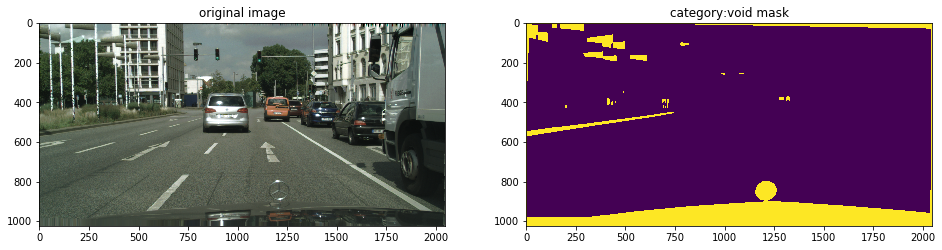

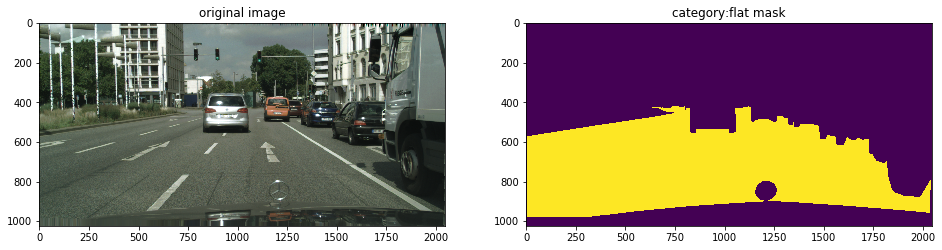

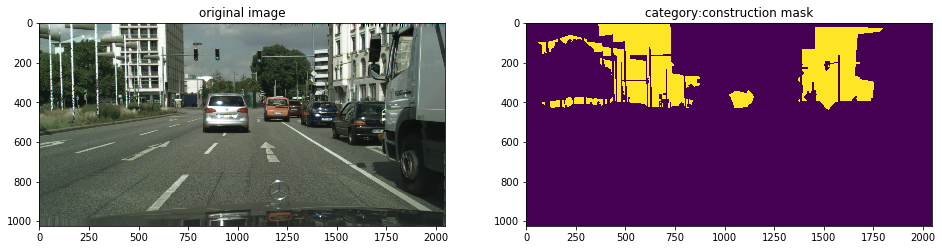

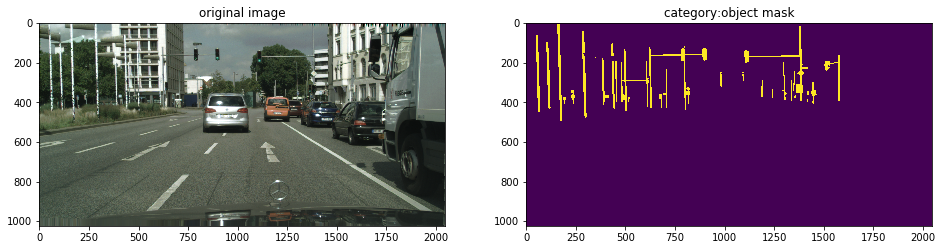

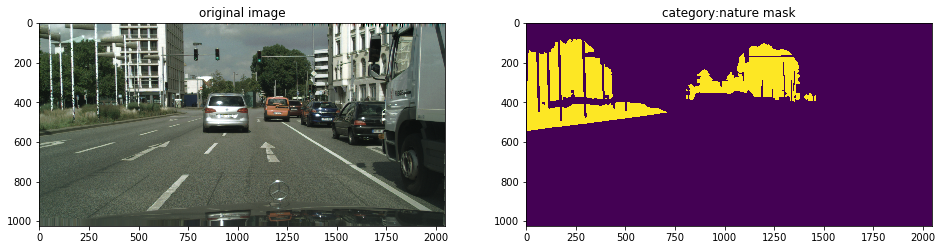

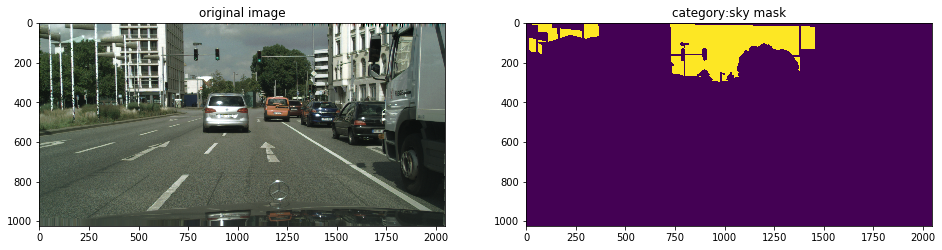

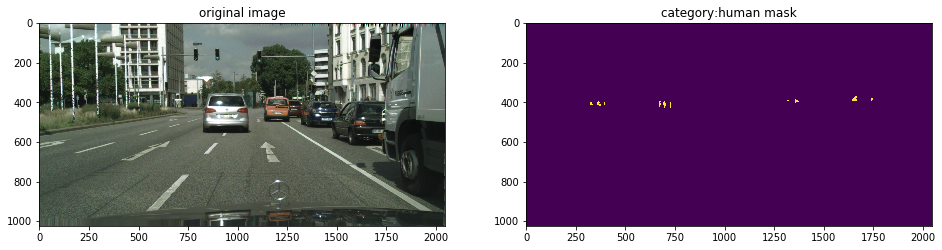

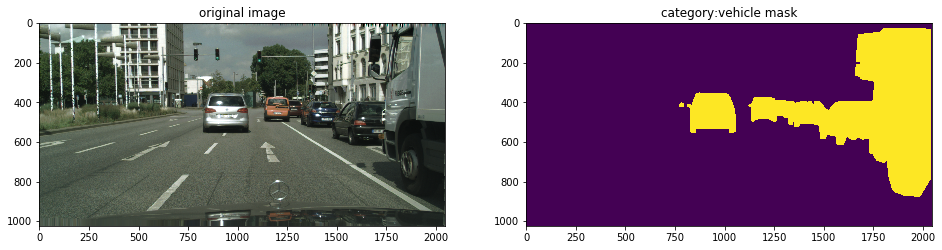

In [4]:
import random
import numpy as np
im=im.numpy() # convert to numpy for visualization 
ma=ma.numpy()

def seperate_masks_by_category(ma, category):
    new=[]
    n,m=ma.shape[:-1]
    categories=list(category.values())
    for k,v in category.items():
        print("category is now:", k," with indice: ", v)
        cat_temp = np.empty(shape = ma.shape[:-1], dtype = ma.dtype)
        for i in range(n):
            for j in range(m):
                if np.argmax(ma[i,j])==v:
                    cat_temp[i][j]=1
                else:
                    cat_temp[i][j]=0
        new.append(cat_temp)
    return np.array(new)
out=seperate_masks_by_category(ma, category)
out.shape
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(8):
    plt.figure(figsize = (16,16))
    plt.subplot(1,2,1)
    plt.imshow(im.astype(np.uint8))
    plt.title("original image")
    plt.subplot(1,2,2)
    plt.imshow(out[i].astype(np.uint8))
    plt.title("category:{} mask".format(reversed_category[i]))

    plt.show()               

### ====== How to split tf.data to train and val
### option 1: if you don't know the dataset size ========

In [5]:
#split to train and val

def is_test(x,y):
    return x%4==0
def is_train(x,y):
    return not is_test(x,y)
recover = lambda x,y:y

test_dataset=dataset.enumerate().filter(is_test).map(recover)
train_dataset = dataset.enumerate().filter(is_train).map(recover)
i=0
for dtest in test_dataset:
    i+=1
j=0
for dtrain in train_dataset:
    j+=1
print("test data count ",i)
print("train data count ",j)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
test data count  744
train data count  2231


### ====== How to split tf.data to train and val
### option 2: if you already know the dataset size ========

In [6]:
#### another way if you know the exact number for train and test
traind=dataset.take(2231)
testd=dataset.skip(744)

Executing op SkipDataset in device /job:localhost/replica:0/task:0/device:CPU:0


#### ================== we need a function to prepare tf.data as batch to feed to the model ==================

In [7]:
batch_size = 4 # noted this is a full resolution image 1024 , 2048, 3, to avoid OOM error, 1 batch_size is used 

def prepare_for_training(ds, shuffle_buffer_size=128 , use_shard=False):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    if use_shard:
        ds = ds.shard(num_gpus, device_id)
        ds = ds.repeat()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # Repeat forever
    
    ds = ds.batch(batch_size)
    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds
#train_ds = prepare_for_training(dataset)
#image_batch, label_batch = next(iter(train_ds))

In [4]:
# use for debugging , not need to run through 
"""
train_ds = prepare_for_training(dataset)
# check the output is what we desired , since the batch_size is  set to 2, so we should have a pair of batch_image=(2,1024,2048,3), label_batch=(2,1024,2048,31)
image_batch, label_batch = next(iter(train_ds))
image_batch.shape,label_batch.shape"""


'\ntrain_ds = prepare_for_training(dataset)\n# check the output is what we desired , since the batch_size is  set to 2, so we should have a pair of batch_image=(2,1024,2048,3), label_batch=(2,1024,2048,31)\nimage_batch, label_batch = next(iter(train_ds))\nimage_batch.shape,label_batch.shape'

### ======== import basic unet model and loss metric ========

In [8]:
from hvd.unet import custom_unet
from loss_metrics import dice_loss, combined_dice_binary_loss , dice_coef
import time
AUTOTUNE = tf.data.experimental.AUTOTUNE
img_files = tf.data.Dataset.list_files('/workspace/8data/img/*.png')
dataset=img_files.map(lambda x: process_path(x)) 
# adapt the data types, images to fp16, gt (one_hot) stay in int close before softmax calc
dataset = dataset.map(adapt_types_and_transpose)
dataset = dataset.map(one_hot)
train_ds = prepare_for_training(dataset)

USE_AMP = False
USE_XLA = False
# what is XLA: Optimizing Compiler for Machine Learning 
#reference url : https://www.tensorflow.org/xla

if USE_XLA:
    tf.config.optimizer.set_jit(USE_XLA)

# marking time
startTime=time.time()
if USE_AMP:
    tf.keras.mixed_precision.experimental.set_policy('mixed_float16')
with tf.device('/cpu'):
    input_shape=(1024,2048, 3)
    cpu_model=custom_unet(input_shape,
    num_classes=len(category),
    use_batch_norm=False, 
    upsample_mode='decov', # 'deconv' or 'simple' 
    use_dropout_on_upsampling=True, 
    dropout=0.5, 
    dropout_change_per_layer=0.0,
    filters=17,
    num_layers=1,
    output_activation='softmax')

    
    opt= tf.optimizers.Adam(1e-4) 
    cpu_model.compile(optimizer=opt, loss=combined_dice_binary_loss, metrics=[dice_coef],experimental_run_tf_function=False)
    data, target = next(iter(train_ds))
    data = data / 255.
    print("data shape: {}".format(data.get_shape()))
    # directly call the fit function
    
    for epochs in range(10):
        cpu_model.fit(data,target)
print('Using _CPU_ only took {0} seconds'.format(time.time() - startTime))
cpu_model.save_weights('checkpt/cpu')

(None, None, 3) (None, None, 1)
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Execu

###  ======== use one gpu to train WITHOUT mixed precision ========
#### specify the gpu number available using nvidia-smi to check , otherwise you will get "resource exhaution error" 

In [9]:
from hvd.unet import custom_unet
from loss_metrics import dice_loss, combined_dice_binary_loss , dice_coef
import time

AUTOTUNE = tf.data.experimental.AUTOTUNE
img_files = tf.data.Dataset.list_files('/workspace/8data/img/*.png')
dataset=img_files.map(lambda x: process_path(x)) 
# adapt the data types, images to fp16, gt (one_hot) stay in int close before softmax calc
dataset = dataset.map(adapt_types_and_transpose)
dataset = dataset.map(one_hot)
train_ds = prepare_for_training(dataset)

USE_AMP = False
USE_XLA = True
if USE_XLA:
    tf.config.optimizer.set_jit(USE_XLA)

if USE_AMP:
    tf.keras.mixed_precision.experimental.set_policy('mixed_float16')
startTime=time.time()
with tf.device('/gpu:5'):
    input_shape=(1024,2048, 3)
    one_device_model=custom_unet(input_shape,
    num_classes=len(category),
    use_batch_norm=False, 
    upsample_mode='simple', # 'deconv' or 'simple' 
    use_dropout_on_upsampling=True, 
    dropout=0.5, 
    dropout_change_per_layer=0.0,
    filters=17,
    num_layers=1,
    output_activation='softmax')

    
    opt= tf.optimizers.Adam(1e-4) 
    one_device_model.compile(optimizer=opt, loss=combined_dice_binary_loss, metrics=[dice_coef],experimental_run_tf_function=False)
    data, target = next(iter(train_ds))
    #print("use for sharding the dataset",hvd.local_size(), hvd.local_rank())
    #dataset=dataset.shard(hvd.local_size(),hvd.local_rank())
    data = data / 255.
    print("data shape: {}".format(data.get_shape()))
    # directly call the fit function

    for epochs in range(10):
        one_device_model.fit(data,target)

print('Using 1 _GPU_ only took {0} seconds'.format(time.time() - startTime))
one_device_model.save_weights('checkpt/ck')

(None, None, 3) (None, None, 1)
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteRandomSeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:5
Exe

###  ===============================================================

###  ======== use one gpu to train WITH mixed precision ========

In [11]:
from hvd.unet import custom_unet
from loss_metrics import dice_loss, combined_dice_binary_loss , dice_coef
import time
AUTOTUNE = tf.data.experimental.AUTOTUNE
img_files = tf.data.Dataset.list_files('/workspace/8data/img/*.png')
dataset=img_files.map(lambda x: process_path(x)) 
# adapt the data types, images to fp16, gt (one_hot) stay in int close before softmax calc
dataset = dataset.map(adapt_types_and_transpose)
dataset = dataset.map(one_hot)
train_ds = prepare_for_training(dataset)
# experimental policy mixed precision https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/experimental/Policy
USE_AMP = True # turn on mixed precision training
USE_XLA = True

tf.config.optimizer.set_jit(USE_XLA)

startTime=time.time()
if USE_AMP:
    tf.keras.mixed_precision.experimental.set_policy('mixed_float16')
with tf.device('/gpu:6'):
    input_shape=(1024,2048,3)
    one_device_model=custom_unet(input_shape,
        num_classes=len(category),
        use_batch_norm=False, 
        upsample_mode='simple', # 'deconv' or 'simple' 
        use_dropout_on_upsampling=True, 
        dropout=0.5, 
        dropout_change_per_layer=0.0,
        filters=17,
        num_layers=1,
        output_activation='softmax')
    opt= tf.optimizers.Adam(1e-4) 
    one_device_model.compile(optimizer=opt, loss=combined_dice_binary_loss, metrics=[dice_coef],experimental_run_tf_function=False)
    data, target = next(iter(train_ds))
    #print("use for sharding the dataset",hvd.local_size(), hvd.local_rank())
    #dataset=dataset.shard(hvd.local_size(),hvd.local_rank())
    data = data / 255.
    print("data shape: {}".format(data.get_shape()))
    # directly call the fit function
    one_device_model.fit(data,target, epochs=10)

print('Using 1 _GPU_ and _Mixed_Precision_ took {0} seconds'.format(time.time() - startTime))
one_device_model.save_weights('checkpt/gpus')

(None, None, 3) (None, None, 1)
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:6
Exec

### ================== use distributed strategy to train on multi-gpus with 1 node ==================

In [3]:
import tensorflow as tf
from hvd.unet import custom_unet
from loss_metrics import dice_loss, combined_dice_binary_loss , dice_coef
import time
# configure to use mixed precison training
USE_AMP = True
USE_XLA = True
if USE_XLA:
    tf.config.optimizer.set_jit(USE_XLA)
# Load Dataset
# This `fit` call will be distributed on 8 GPUs.
AUTOTUNE = tf.data.experimental.AUTOTUNE
NUM_WORKERS = 8 # number of gpus used for training
# Here the batch size scales up by number of workers , previously we got 4 as base_batch_size, now after scale by the num_gpus, we got 4*8=32

batch_size = 4 * NUM_WORKERS 
def tf_data_pipeline_fn():
    img_files = tf.data.Dataset.list_files('/workspace/8data/img/*.png')
    dataset=img_files.map(lambda x: process_path(x)) 
    # adapt the data types
    dataset = dataset.map(adapt_types_and_transpose)
    dataset = dataset.map(one_hot)
    dataset = dataset.prefetch(buffer_size=128)
    dataset = dataset.cache().shuffle(buffer_size=128).repeat()
    return dataset

#### sharding possible with autoshard policy but you will have to wait for TF-nightly build for the container ##### 
#options=tf.data.Options()
#options.experimenta_distribute.auto_shard_policy=tf.data.experimental.AutoShardPolicy.ON
##### shard policy end 

devices = ['/device:GPU:{}'.format(i) for i in range(NUM_WORKERS)] # make sure you pass the available devices into strategy , otherwise Assertion error will arise
strategy = tf.distribute.MirroredStrategy(devices) # this is the strategy for 1 node but multiple gpus
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
startTime=time.time()
if USE_AMP:
    tf.keras.mixed_precision.experimental.set_policy('mixed_float16')
with strategy.scope():
    dataset = tf_data_pipeline_fn().batch(batch_size)
    #dataset_shard=dataset.withoptions(options) can use sharding AFTER TF-nightly is released 
    opt = tf.optimizers.Adam(1e-4) 
    input_shape=(1024,2048,3)
    parallel_model=custom_unet(input_shape,
        num_classes=8,
        use_batch_norm=False, 
        upsample_mode='deconv', 
        use_dropout_on_upsampling=True, 
        dropout=0.3, 
        dropout_change_per_layer=0.0,
        filters=7,
        num_layers=4,
        output_activation='softmax')
    parallel_model.compile(optimizer=opt, loss=combined_dice_binary_loss, metrics=[dice_coef],experimental_run_tf_function=False)
# directly call the fit function
parallel_model.fit(dataset, epochs=100,steps_per_epoch=1)
print('Using 8 GPUs with TF2 Mirrored Strategy training and add MixedPrecision took {0} seconds'.format(time.time() - startTime))
parallel_model.save_weights('checkpt/8gpu1node')



Number of devices: 8
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
(None, None, 3) (None, None, 1)
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMemoryCache in device /job:localh

In [11]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]